Written by Gokmen Dedemen (gd1097) and modified by Bianca Brusco (bb1569)

In [4]:
from __future__  import print_function, division
import requests, zipfile,io
from io import StringIO
from zipfile import ZipFile
from urllib.request import urlopen
import pandas as pd
import pylab as pl
import seaborn as sns
import numpy as np
%pylab inline

#MY REFERENCE:
#https://stac koverflow.com/questions/9419162/python-download-returned-zip-file-from-url
def getData(datestring):
    
    #datestring="201501"
    zip_file_url = ("https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    df = pd.read_csv(z.open(datestring+'-citibike-tripdata.csv'))
    return df

Populating the interactive namespace from numpy and matplotlib


My reference for how to read csv file from a zip file (the code in the cell above)
https://stackoverflow.com/questions/9419162/python-download-returned-zip-file-from-url

## IDEA:

CitiBike subscribers are more likely to use the service for shorter trips than consumers. 

### NULL HYPOTESIS (H0): 

The ratio of trips longer than average over trips shorter than average for subscribers is the same or greater than the same ratio for consumers. 

$H_0 : \frac{S_{long}}{S_{short}} \geq \frac{C_{long}}{C_{short}}$


### ALTERNATIVE HYPOTESIS(HA):
The ratio of trips longer than average over trips shorter than average for subscribers is lower than the same ratio for consumers. 

$H_A : \frac{S_{long}}{S_{short}} < \frac{C_{long}}{C_{short}}$

I will use a significance level  $\alpha=0.05$
which means I want the probability of getting a result at least as significant as mine to be less then 5%

Note: As suggested by ssb602, I include an equation and make the formulation of my null and alternative hypothesis shorter.

In [5]:
df = getData('201501')
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1


In [6]:
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

### Exploration of the Data

In [7]:
DF = df[['tripduration','usertype']]
DF['tripduration']=(DF['tripduration']/60) #to convert seconds to minutes

/Users/biancabrusco/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
#checking the unique user types for citibike
DF.usertype.unique()

array(['Subscriber', 'Customer'], dtype=object)

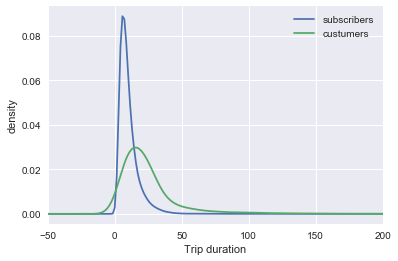

In [9]:
pl.figure()
subs = DF[DF['usertype']=='Subscriber']
cust = DF[DF['usertype']=='Customer']

ax = subs.tripduration.plot.kde(label="subscribers")
ax = cust.tripduration.plot.kde(label="custumers")
pl.legend();
ax.set(xlim=(-50,200))
pl.xlabel("Trip duration")
pl.ylabel("density")

**Figure 1** Distribution of trip duration for subscribers and costumers. 

In [7]:
DF.describe()

,tripduration
count,285552.000000
mean,10.905426
std,15.012932
min,1.000000
25%,5.566667
50%,8.400000
75%,12.866667
max,717.050000


In [10]:
DF.groupby('usertype').describe()

tripduration                                                  \
                  count       mean       std  min        25%        50%   
usertype                                                                  
Customer         5628.0  26.487038  35.23803  1.0  11.400000  19.141667   
Subscriber     279924.0  10.592151  14.14140  1.0   5.533333   8.300000   

                               
                  75%     max  
usertype                       
Customer    28.620833  677.70  
Subscriber  12.616667  717.05

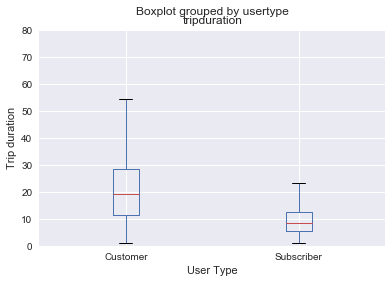

In [14]:
bp = DF.boxplot(by="usertype")
bp.set(ylim=(0,80));
pl.xlabel("User Type");
pl.ylabel("Trip duration");

**Figure 2** Boxplot for trip duration, by user type. 

Since the mean value of trip duration of the users is 10.9 minutes, users whose trip takes above 11 minutes are considered as 
users with longer trip duration. Here we define a criteria for long and short trips and we create new columns for these in the form of boolean data.

In [15]:
DF['longTrip'] = DF['tripduration']>11
DF['shortTrip'] = DF['tripduration']<=11

/Users/biancabrusco/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/biancabrusco/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
DF.head()

,tripduration,usertype,longTrip,shortTrip
0,22.433333,Subscriber,True,False
1,6.050000,Subscriber,False,True
2,5.766667,Subscriber,False,True
3,3.033333,Subscriber,False,True
4,16.150000,Subscriber,True,False


In [12]:
df_subscribers = DF[DF.usertype=='Subscriber']
df_subscribers.head()

,tripduration,usertype,longTrip,shortTrip
0,22.433333,Subscriber,True,False
1,6.050000,Subscriber,False,True
2,5.766667,Subscriber,False,True
3,3.033333,Subscriber,False,True
4,16.150000,Subscriber,True,False


In [13]:
df_customers = DF[DF.usertype=='Customer']
df_customers.head()

,tripduration,usertype,longTrip,shortTrip
24,20.850000,Customer,True,False
26,8.383333,Customer,False,True
28,19.583333,Customer,True,False
34,16.133333,Customer,True,False
38,14.383333,Customer,True,False


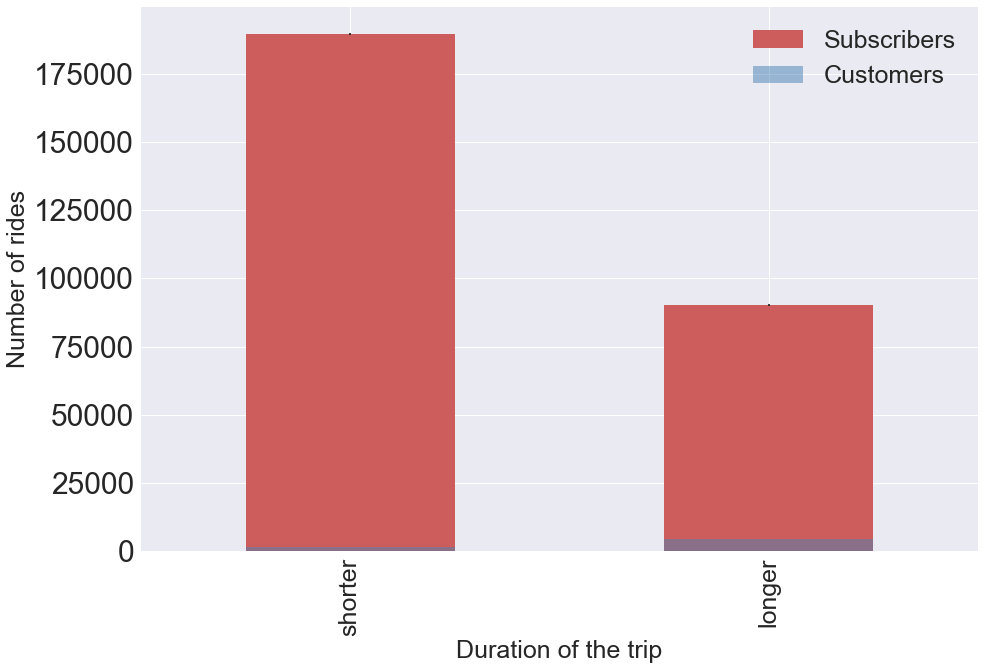

In [14]:
pl.figure(figsize=(15,10))

#What is the count of subscribers for long and short trips. Let us calculate it
counts_subscribers = df_subscribers.tripduration.groupby([df_subscribers.longTrip]).count()
norm_subscribers = 1
error_subscribers = np.sqrt(counts_subscribers)

((counts_subscribers) / norm_subscribers).plot(kind="bar",color='IndianRed', 
                                               yerr=[((error_subscribers)/ norm_subscribers, (error_subscribers) / norm_subscribers)],
                                               label = 'SteelBlue') 
                                               


# What is the count of customers for long and short trips. Let us calculate it.
counts_customers = df_customers.tripduration.groupby([df_customers.longTrip]).count()
norm_customers = 1
error_customers = np.sqrt(counts_customers)
ax = ((counts_customers) / norm_customers).plot(kind="bar", alpha=0.5, label='Customers', yerr=[((error_customers) / norm_customers, (error_customers) / norm_customers)],
                                              color='SteelBlue')


pl.yticks(fontsize=30)
ax.xaxis.set_ticklabels(['shorter','longer'], fontsize=25)


ax.set_ylabel ("Number of rides", fontsize=25)
ax.set_xlabel ("Duration of the trip", fontsize=25)
pl.legend(['Subscribers','Customers'],fontsize=25)
pl.show()

**Figure 3**:Distribution of Citibike bikers by user type in January 2015, absolute counts, with statistical errors¶

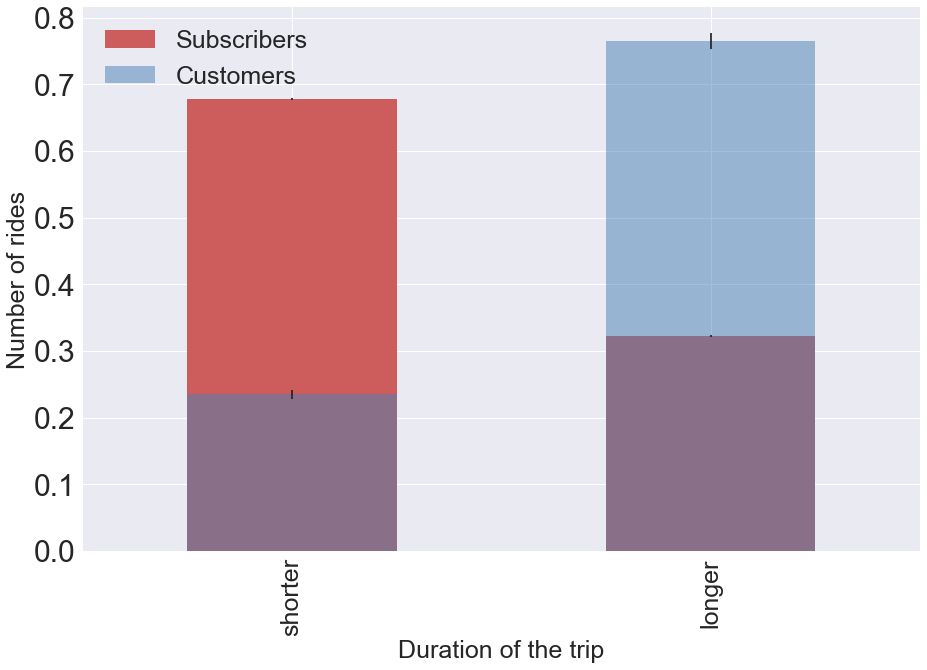

In [15]:
pl.figure(figsize=(15,10))


#What is the count of subscribers for long and short trips. Let us calculate it
counts_subscribers = df_subscribers.tripduration.groupby([df_subscribers.longTrip]).count()
norm_subscribers = counts_subscribers.sum()
error_subscribers = np.sqrt(counts_subscribers)

((counts_subscribers) / norm_subscribers).plot(kind="bar",color='IndianRed', 
                                               yerr=[((error_subscribers)/ norm_subscribers, (error_subscribers) / norm_subscribers)],
                                               label = 'SteelBlue') 
                                               


# What is the count of customers for long and short trips. Let us calculate it.
counts_customers = df_customers.tripduration.groupby([df_customers.longTrip]).count()
norm_customers = counts_customers.sum()
error_customers = np.sqrt(counts_customers)
ax = ((counts_customers) / norm_customers).plot(kind="bar", alpha=0.5, label='Customers', yerr=[((error_customers) / norm_customers, (error_customers) / norm_customers)],
                                              color='SteelBlue')


pl.yticks(fontsize=30)
ax.xaxis.set_ticklabels(['shorter','longer'], fontsize=25)


ax.set_ylabel ("Number of rides", fontsize=25)
ax.set_xlabel ("Duration of the trip", fontsize=25)
pl.legend(['Subscribers','Customers'],fontsize=25)

**Figure 4**: Distribution of Citibike bikers by user type in January 2015, normalized. We see that while subscribers take more shorter trips, consumers take more longer trips. 

In [16]:
counts_customers

longTrip
False    1321
True     4307
Name: tripduration, dtype: int64

In [17]:
counts_subscribers

longTrip
False    189661
True      90263
Name: tripduration, dtype: int64

## Testing if the two proportions are equal

In [18]:
longer_customers = counts_customers[1]/ norm_customers
#the fraction of customers taking longer trip duration 
shorter_customers = counts_customers[0]/norm_customers #fraction of customers taking shorter trip duration
longer_subscribers = counts_subscribers[1]/ norm_subscribers#the fraction of customers taking longer trip duration 
shorter_subscribers = counts_subscribers[0]/norm_subscribers #fraction of customers taking shorter trip duration

In [19]:
P0mP1 = (longer_subscribers/shorter_subscribers - longer_customers/shorter_customers)
print ("difference between subscribers and customers on shorter trips: ", P0mP1)
if P0mP1 >= 0:
    # we are done...
    print("In accordance with Null Hypothesis")
else:
    # morework to do
    print ("We must check the significance before we reject the Null Hypothesis")


difference between subscribers and customers on shorter trips:  -2.78449122306
We must check the significance before we reject the Null Hypothesis


In [20]:
my_p0 = longer_subscribers/shorter_subscribers  
my_p1 = longer_customers/shorter_customers

#Is this difference statistically significant?

In [21]:
p = lambda p0, p1, n0, n1: (p0 * n0 + p1 * n1) / (n0 + n1)
se = lambda p, n0, n1: np.sqrt(p * (1 - p) * (1.0 / n0 + 1.0 / n1)) #standard error
zscore = lambda p0, p1, s : (p0 - p1) / s

# calculations

my_p = p(my_p0,my_p1,norm_subscribers,norm_customers)
my_se = se(my_p,norm_subscribers,norm_customers)
z = zscore(my_p0, my_p1,my_se)
print ("The z statistics is %.2f"%z)


The z statistics is -414.43


The largest number reported in z stats tables is (typically) 3, which gives a p value p<0.0002, which is smaller then my chosen  $\alpha = 0.05$ - so yes, it is statistically significant (by a lot!)

__Interpretation__ : 

We reject the null hypothesis, and conclude that the ratio of longer/shorter trips is smaller for subscribers than for customers. 
Therefore, from this analysis it appears that subscribers are more likely to use Citi-Bike for shorter trips compared to customers. 

*Note* : ssb602 suggest to use a Z test, and this is appropriate given that we are testing two sample proportions to see if they come from the same population.